### By:
##### Karthik Bhat Beedubail
##### Date: 24 March 2024


# Part A. Read and Query Data
Access data from “Daily Climate Observations” from GeoMET API (https://ecccmsc.github.io/opendata/msc-geomet/readme_en/). Extract data, using the OWSLIB using Jupyter 
Notebook for the closest observation station to '560 Rochester St, Ottawa, ON, CA' for the entirety of
2011.

**Solution:**
First lets see how the API is working. I found these 2 swagger documentation helpful to understand the API behaviour and plan my approach. As per documentation GeoJsons are in WGS 84 format, which is EPSG:4326 in geopanda. 

Station info <b> https://api.weather.gc.ca/openapi#/climate-stations/getClimate-stationsFeatures)</b> <br>
Climate data <b> https://api.weather.gc.ca/openapi#/climate-daily/getClimate-dailyFeatures</b>

By using "Try it out" option of above Swagger Documents, we can perform little bit of analysis on how data is mapped. <br>

from `climate-stations` we can query stations info with aid of `bbox` . It will give us list of station that intesets the bounding box. From that list we can get Station Id (STN_ID). Then use that `STN_ID` along with `datetime` bounded interval to fetch the daily climate data

For this approach we will create a small boundingbox around the address, then fetch stations list, then identify closest station, then fetch climate data of that station.

In [195]:
from datetime import date
from owslib.ogcapi.features import Features
import geopandas as gpd
import requests
from urllib.parse import quote

In [196]:
# Define the co-ordinate for the address 560 Rochester St, Ottawa, ON, CA
latitude = 45.408157
longitude = -75.708500

# Start and end of the time period for which the data will be retrieved
start_date = date(2011, 1, 1)
end_date = date(2011, 12, 31)

#lets create a bounding box
delta = 0.03 # adjust this if no stations found

# Create bbox: (min longitude, min latitude, max longitude, max latitude)
bbox = [longitude - delta, latitude - delta, longitude + delta, latitude + delta]

(I tried using Nominatim API from OpenStreetMap to fetch the latitude and longitude for the address (https://nominatim.org/release-docs/develop/api/Search/). For some reason API was failing with 403 error. Instead Here I have hardcoded lat and long by manually searching it in Google maps.)

Now lets initialize an instance of the Features class with the base URL of the Weather API provided by Environment Canada.

In [200]:
oafeat = Features("https://api.weather.gc.ca/")

In [204]:
# The method `collection_items` is used to retrieve items from a specified collection—in this case, "climate-stations".
station_data = oafeat.collection_items(
    "climate-stations", bbox=bbox, 
)

In [205]:
stations_gdf = gpd.GeoDataFrame.from_features(station_data)
#Let's set crs in dataframe since it is not explicitly present.
if stations_gdf.crs is None:
    stations_gdf.set_crs(epsg=4326, inplace=True)

In [206]:
stations_gdf

,geometry,STN_ID,STATION_NAME,PROV_STATE_TERR_CODE,ENG_PROV_NAME,FRE_PROV_NAME,COUNTRY,LATITUDE,LONGITUDE,TIMEZONE,...,LAST_DATE,HLY_FIRST_DATE,HLY_LAST_DATE,DLY_FIRST_DATE,DLY_LAST_DATE,MLY_FIRST_DATE,MLY_LAST_DATE,HAS_MONTHLY_SUMMARY,HAS_NORMALS_DATA,HAS_HOURLY_DATA
0,POINT (-75.71667 45.38333),4333,OTTAWA CDA,ON,ONTARIO,ONTARIO,CAN,452300000,-754300000,EST,...,2024-03-07 00:00:00,None,None,1889-11-01 00:00:00,2024-03-07 00:00:00,1889-01-01 00:00:00,2006-12-01 00:00:00,N,Y,N
1,POINT (-75.68333 45.41667),4346,OTTAWA U OF O,ON,ONTARIO,ONTARIO,CAN,452500000,-754100000,EST,...,1955-12-01 00:00:00,None,None,1954-10-01 00:00:00,1955-03-31 00:00:00,1954-01-01 00:00:00,1955-12-01 00:00:00,Y,N,N
2,POINT (-75.71667 45.38333),30578,OTTAWA CDA RCS,ON,ONTARIO,ONTARIO,CAN,452300000,-754300000,EST,...,2024-03-22 12:30:01,2000-10-19 18:00:00,2024-03-22 12:30:01,2000-10-19 00:00:00,2024-03-22 00:00:00,2003-04-01 00:00:00,2006-12-01 00:00:00,Y,N,Y
3,POINT (-75.70000 45.43333),4339,OTTAWA LA SALLE ACAD,ON,ONTARIO,ONTARIO,CAN,452600000,-754200000,EST,...,1967-12-01 00:00:00,None,None,1954-12-01 00:00:00,1967-06-30 00:00:00,1954-01-01 00:00:00,1967-12-01 00:00:00,Y,N,N
4,POINT (-75.70000 45.43333),4334,OTTAWA CITY HALL,ON,ONTARIO,ONTARIO,CAN,452600000,-754200000,EST,...,1975-12-01 00:00:00,None,None,1966-06-01 00:00:00,1975-04-30 00:00:00,1966-01-01 00:00:00,1975-12-01 00:00:00,Y,N,N
5,POINT (-75.73333 45.41667),4340,OTTAWA LEMIEUX ISLAND,ON,ONTARIO,ONTARIO,CAN,452500000,-754400000,EST,...,1979-12-01 00:00:00,None,None,1953-10-01 00:00:00,1979-04-30 00:00:00,1953-01-01 00:00:00,1979-12-01 00:00:00,Y,N,N
6,POINT (-75.71667 45.40000),4327,OTTAWA,ON,ONTARIO,ONTARIO,CAN,452400000,-754300000,EST,...,1935-12-01 00:00:00,None,None,1872-03-01 00:00:00,1935-03-31 00:00:00,1872-01-01 00:00:00,1935-12-01 00:00:00,Y,N,N


Now by observing this dataframe contains climate stations that are inside our bounding box. Which are technically close to our given Longitude and Lattitude.
<br>
Now our task is to find <b>closest station that has climate-daily data in the given time period.</b> <br>
This can be done by checking the DLY_FIRST_DATE and DLY_LAST_DATE fields against our `start_date` and `end_date`. 

and to find closest station lets use great_circle method from geopy package. which is an approximation of the shortest distance over the earth's surface.<br>
(ref: https://geopy.readthedocs.io/en/stable/#geopy.distance.great_circle) 

In [207]:
from geopy.distance import great_circle

def find_closest_station_with_data(gdf, latitude, longitude, start_date, end_date):
    closest_station = None
    min_distance = float('inf')
    
    for index, row in gdf.iterrows():
        # Convert lat and long to decimal degrees
        station_lat = row['LATITUDE'] / 10000000
        station_lon = row['LONGITUDE'] / 10000000
        
        # Check if the station has climate-daily data within the given period
        station_start = date.fromisoformat(row['DLY_FIRST_DATE'][:10]) if row['DLY_FIRST_DATE'] else None
        station_end = date.fromisoformat(row['DLY_LAST_DATE'][:10]) if row['DLY_LAST_DATE'] else None
        if station_start is None or station_end is None:
            continue  # Skip stations without available data
        if station_start <= end_date and station_end >= start_date:
            # Calculate the distance to the station
            distance = great_circle((latitude, longitude), (station_lat, station_lon)).kilometers
            if distance < min_distance:
                min_distance = distance
                closest_station = row
                
    return closest_station

closest_station = find_closest_station_with_data(stations_gdf, latitude, longitude, start_date, end_date)
if closest_station is not None:
    print("Closest station with data:", closest_station['STN_ID'], closest_station['STATION_NAME'])
else:
    print("No station meets the criteria.")


Closest station with data: 4333 OTTAWA CDA


In [208]:
climate_data = oafeat.collection_items(
    "climate-daily",
    bbox=bbox,
    datetime=f"{start_date}/{end_date}",
    STN_ID=closest_station['STN_ID'],
)
climate_data

{'type': 'FeatureCollection',
 'features': [{'id': '6105976.2011.1.1',
   'type': 'Feature',
   'geometry': {'coordinates': [-75.71666666666667, 45.38333333333333],
    'type': 'Point'},
   'properties': {'COOLING_DEGREE_DAYS_FLAG': None,
    'MIN_REL_HUMIDITY_FLAG': None,
    'COOLING_DEGREE_DAYS': 0,
    'CLIMATE_IDENTIFIER': '6105976',
    'SNOW_ON_GROUND_FLAG': None,
    'MAX_TEMPERATURE': 7.7,
    'HEATING_DEGREE_DAYS_FLAG': None,
    'LOCAL_DAY': 1,
    'STATION_NAME': 'OTTAWA CDA',
    'HEATING_DEGREE_DAYS': 13.3,
    'ID': '6105976.2011.1.1',
    'LOCAL_YEAR': 2011,
    'PROVINCE_CODE': 'ON',
    'SNOW_ON_GROUND': 0,
    'DIRECTION_MAX_GUST': None,
    'TOTAL_PRECIPITATION_FLAG': None,
    'MAX_TEMPERATURE_FLAG': None,
    'TOTAL_RAIN': 4.2,
    'TOTAL_PRECIPITATION': 4.2,
    'TOTAL_SNOW_FLAG': None,
    'MIN_REL_HUMIDITY': None,
    'DIRECTION_MAX_GUST_FLAG': None,
    'SPEED_MAX_GUST': None,
    'LOCAL_DATE': '2011-01-01 00:00:00',
    'MIN_TEMPERATURE_FLAG': None,
    'MEAN

Now lets put this in a dataframe. (I like to keep things in data frame to analyze)

In [211]:
climate_data_gdf = gpd.GeoDataFrame.from_features(climate_data)
#Let's set crs in dataframe since it is not explicitly present sometimes. This is not required but i prefer to have it.
if climate_data_gdf.crs is None:
    stations_gdf.set_crs(epsg=4326, inplace=True)

In [212]:
climate_data_gdf

,geometry,COOLING_DEGREE_DAYS_FLAG,MIN_REL_HUMIDITY_FLAG,COOLING_DEGREE_DAYS,CLIMATE_IDENTIFIER,SNOW_ON_GROUND_FLAG,MAX_TEMPERATURE,HEATING_DEGREE_DAYS_FLAG,LOCAL_DAY,STATION_NAME,...,MIN_TEMPERATURE_FLAG,MEAN_TEMPERATURE,SPEED_MAX_GUST_FLAG,LOCAL_MONTH,TOTAL_RAIN_FLAG,TOTAL_SNOW,MIN_TEMPERATURE,MEAN_TEMPERATURE_FLAG,MAX_REL_HUMIDITY_FLAG,MAX_REL_HUMIDITY
0,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,7.7,None,1,OTTAWA CDA,...,None,4.7,None,1,None,0.0,1.7,None,None,None
1,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,1.2,None,2,OTTAWA CDA,...,None,-0.5,None,1,None,0.0,-2.2,None,None,None
2,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,-2.0,None,3,OTTAWA CDA,...,None,-3.9,None,1,None,1.0,-5.8,None,None,None
3,POINT (-75.71667 45.38333),None,None,0.0,6105976,T,-3.1,None,4,OTTAWA CDA,...,None,-5.8,None,1,None,1.0,-8.4,None,None,None
4,POINT (-75.71667 45.38333),None,None,0.0,6105976,T,-3.8,None,5,OTTAWA CDA,...,None,-5.4,None,1,None,0.0,-7.0,None,None,None
5,POINT (-75.71667 45.38333),None,None,0.0,6105976,T,-3.5,None,6,OTTAWA CDA,...,None,-7.1,None,1,None,1.8,-10.6,None,None,None
6,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,-4.8,None,7,OTTAWA CDA,...,None,-7.2,None,1,None,2.5,-9.5,None,None,None
7,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,-4.9,None,8,OTTAWA CDA,...,None,-6.5,None,1,None,5.0,-8.0,None,None,None
8,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,-5.9,None,9,OTTAWA CDA,...,None,-8.3,None,1,None,0.0,-10.6,None,None,None
9,POINT (-75.71667 45.38333),None,None,0.0,6105976,None,15.7,None,10,OTTAWA CDA,...,None,8.4,None,4,None,0.0,1.0,None,None,None


Now Lets jump into graphs! <br>
<b>1 Create individual plots for minimum, mean and maximum temperature, and a 4th plot of all 
temperatures in one plot using the subplo  function and aligning the axes</b>.

From above data frame we'll use LOCAL_DATE, MIN_TEMPERATURE, MEAN_TEMPERATURE and MAX_TEMPERATURE columns to achieve this

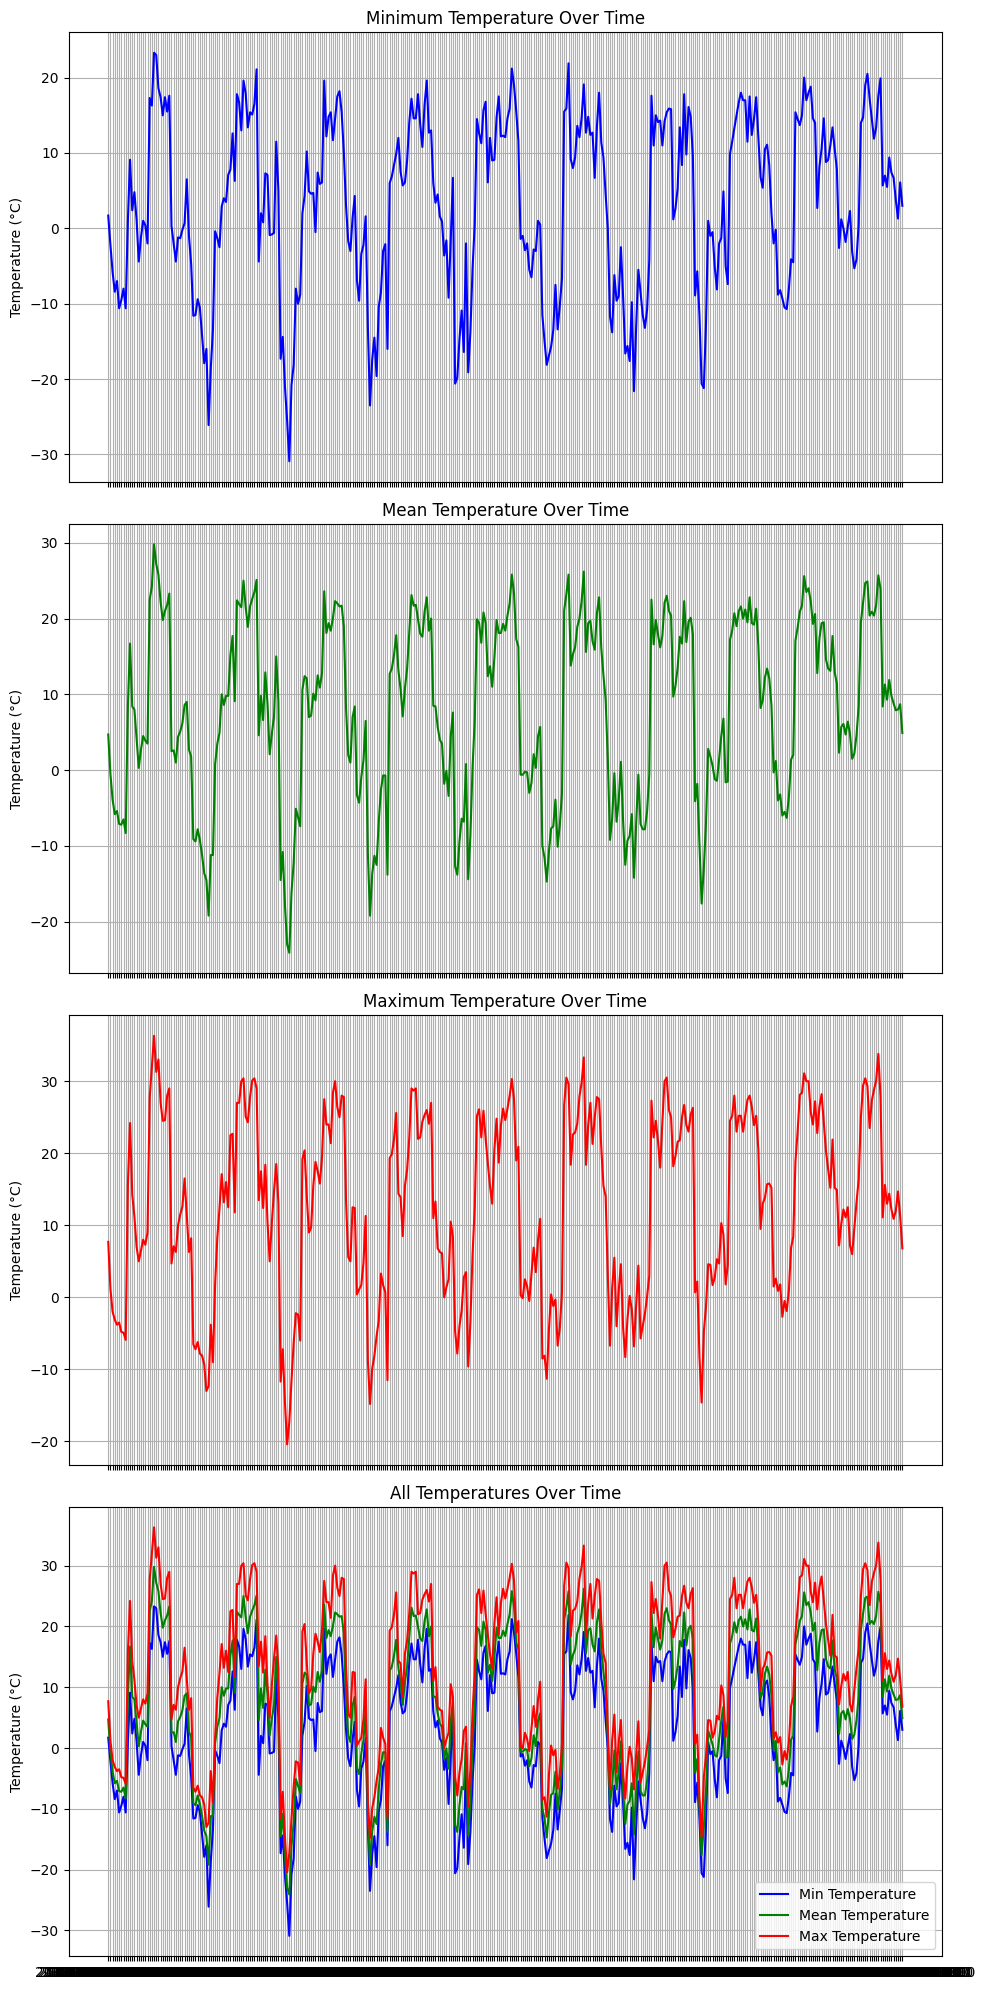

In [213]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(10, 20), sharex=True)

# Minimum Temperature Plot
axs[0].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MIN_TEMPERATURE'], label='Min Temperature', color='blue')
axs[0].set_title('Minimum Temperature Over Time')
axs[0].set_ylabel('Temperature (°C)')
axs[0].grid(True)

# Mean Temperature Plot
axs[1].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MEAN_TEMPERATURE'], label='Mean Temperature', color='green')
axs[1].set_title('Mean Temperature Over Time')
axs[1].set_ylabel('Temperature (°C)')
axs[1].grid(True)

# Maximum Temperature Plot
axs[2].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MAX_TEMPERATURE'], label='Max Temperature', color='red')
axs[2].set_title('Maximum Temperature Over Time')
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(True)

# Combined Temperatures Plot
axs[3].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MIN_TEMPERATURE'], label='Min Temperature', color='blue')
axs[3].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MEAN_TEMPERATURE'], label='Mean Temperature', color='green')
axs[3].plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['MAX_TEMPERATURE'], label='Max Temperature', color='red')
axs[3].set_title('All Temperatures Over Time')
axs[3].set_ylabel('Temperature (°C)')
axs[3].legend()
axs[3].grid(True)

plt.tight_layout() # Adjust layout
plt.show() # Display the plots


#### 2 Plot the cumulative precipitation over the year

From above data frame I am considering TOTAL_PRECIPITATION for Cumulative Precipitation. here I am assuming that the Cumulative is sum of TOTAL_PRECIPITATION over the time. <br>
So I will create new column named `CUMULATIVE_PRECIPITATION` in same climate_data_gdf, to hold the sum. We'll use cumsum()<br>
Ref: https://www.w3schools.com/python/pandas/ref_df_cumsum.asp

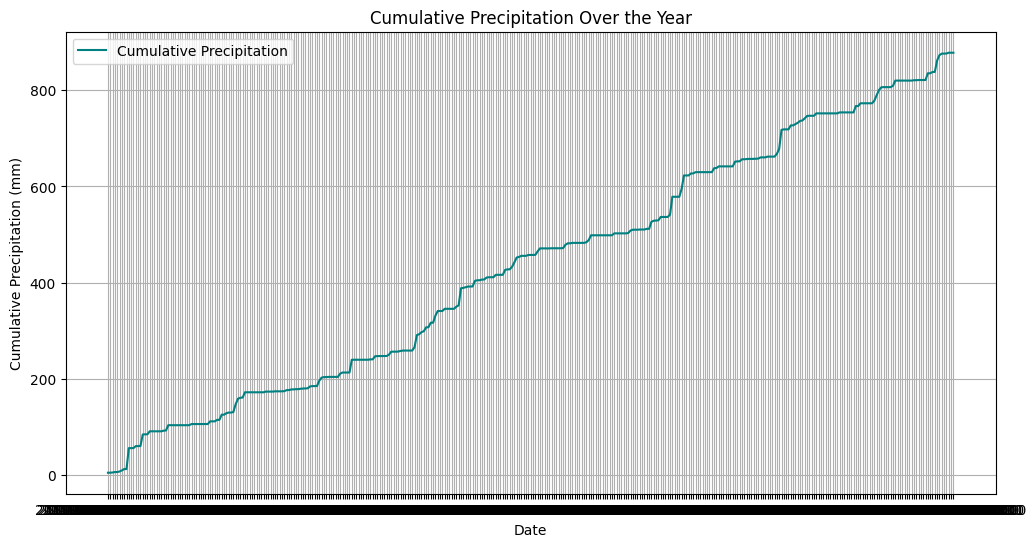

In [214]:
# Calculate cumulative precipitation
climate_data_gdf['CUMULATIVE_PRECIPITATION'] = climate_data_gdf['TOTAL_PRECIPITATION'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(climate_data_gdf['LOCAL_DATE'], climate_data_gdf['CUMULATIVE_PRECIPITATION'], color='teal', label='Cumulative Precipitation')
plt.title('Cumulative Precipitation Over the Year')
plt.xlabel('Date')
plt.ylabel('Cumulative Precipitation (mm)')
plt.grid(True)
plt.legend()
plt.show()

<b>3. Create a geographic map – plot the location of the closest observation station in a folium map
using a custom marker with a pop up that provide some details of the station (e.g.: Station
Name, Station Number, and Latitude, Longitude) and a different style marker at the address
provided.</b>

**Solution:** <br/>
Lets see our `closest_station` tha we found

In [215]:
closest_station

geometry                    POINT (-75.71666666666667 45.38333333333333)
STN_ID                                                              4333
STATION_NAME                                                  OTTAWA CDA
PROV_STATE_TERR_CODE                                                  ON
ENG_PROV_NAME                                                    ONTARIO
FRE_PROV_NAME                                                    ONTARIO
COUNTRY                                                              CAN
LATITUDE                                                       452300000
LONGITUDE                                                     -754300000
TIMEZONE                                                             EST
ELEVATION                                                          79.20
CLIMATE_IDENTIFIER                                               6105976
TC_IDENTIFIER                                                        WCG
WMO_IDENTIFIER                                     

We already have our `latitude` and `longitude` stored. Also, we have alll required data about closest station in `closest_station` variable. Now lets use folium to plot them in an interactive way

In [216]:
import folium
from shapely.geometry import Point

#'geometry' is a Shapely Point object

# Extract coordinates directly from the Shapely Point object
station_point = closest_station['geometry']
station_lat = station_point.y
station_lon = station_point.x

# Provided address location
address_location = {'latitude': 45.408157, 'longitude': -75.708500}

# Create a map centered around the address (one which we defined initially)
m = folium.Map(location=[latitude, longitude], zoom_start=12)

# Add a marker for the closest station with a popup
folium.Marker(
    [station_lat, station_lon],
    popup=f"<strong>Station Name:</strong> {closest_station['STATION_NAME']}<br>"
          f"<strong>Station ID:</strong> {closest_station['STN_ID']}<br>"
          f"<strong>Latitude:</strong> {station_lat}, <strong>Longitude:</strong> {station_lon}",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# Add a different style marker for the provided address
folium.Marker(
    [address_location['latitude'], address_location['longitude']],
    popup="<strong>Our location</strong>",
    icon=folium.Icon(color='red', icon='home')
).add_to(m)

# Display the map
m


#### Click on blue i to interact

# Part B. Data Calculations

Using the data you have downloaded in Part A. Calculate the average of the mean temperature for each
season, using the following dates to denote seasonal boundaries:
Spring: March 20th
Summer: June 21st
Autumn/Fall: Sept 23
Winter: Dec 21th

<b>Solution:</b> <br />
To solve this lets use pandas time stamp. First lets add a `Season` column to our `climate_data_gdf`. Then we'll use mean() funcion with the help of group by season filter. We'll create a get_season function and apply it to each row of the dataframe. <br />
Ref: https://pandas.pydata.org/pandas-docs/version/0.25.0/reference/api/pandas.core.groupby.GroupBy.mean.html <br />

The logic for determining the season based on a given date is as follows:

- **Spring**: From March 20th to June 20th
- **Summer**: From June 21st to September 22nd
- **Autumn**: From September 23rd to December 20th
- **Winter**: From December 21st to March 19th of the following year

In [217]:
import pandas as pd

In [218]:
# Lets just make sure 'LOCAL_DATE' column is already in datetime format
climate_data_gdf['LOCAL_DATE'] = pd.to_datetime(climate_data_gdf['LOCAL_DATE'])

# Function to determine the season for a given date
def get_season(date):
    year = date.year
    if pd.Timestamp(year=year, month=3, day=20) <= date <= pd.Timestamp(year=year, month=6, day=20):
        return 'Spring'
    elif pd.Timestamp(year=year, month=6, day=21) <= date <= pd.Timestamp(year=year, month=9, day=22):
        return 'Summer'
    elif pd.Timestamp(year=year, month=9, day=23) <= date <= pd.Timestamp(year=year, month=12, day=20):
        return 'Autumn'
    else:
        # This will cover dates from December 21 to March 19 as 'Winter'
        return 'Winter'

# Apply the function to determine the season for each row in the DataFrame
climate_data_gdf['Season'] = climate_data_gdf['LOCAL_DATE'].apply(get_season)

# Calculate the average mean temperature for each season
seasonal_avg_temps = climate_data_gdf.groupby('Season')['MEAN_TEMPERATURE'].mean()

seasonal_avg_temps

Season
Autumn     7.057303
Spring    10.880645
Summer    20.581915
Winter    -7.558427
Name: MEAN_TEMPERATURE, dtype: float64

<b>Create a function which generates a plot of each season showing the variation in mean temperature 
throughout the season and indicating the computed average mean temperature in the season.</b> 

<b>Solution:</b> <br/>
Let call our function as `plot_seasonal_temps_with_avg()`. Now function will take climate_data dataframe, seasonal_avg_temps which we calculated in last step, and a season string(Autumn / Spring / Summer or Winter).

In [219]:
def plot_seasonal_temps_with_avg(df, season, seasonal_avg_temps):
    # Filter the DataFrame for the selected season
    season_df = df[df['Season'] == season]
    
    # If there's no data for the season, just return
    if season_df.empty:
        print(f"No data available for {season}.")
        return
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(season_df['LOCAL_DATE'], season_df['MEAN_TEMPERATURE'], label='Daily Mean Temperature', color='skyblue')
    
    # Retrieve the average temperature for the season from the seasonal_avg_temps Series
    avg_temp = seasonal_avg_temps.get(season, None)
    plt.axhline(y=avg_temp, color='r', linestyle='-', label=f'Seasonal Average: {avg_temp:.2f}°C')
    
    plt.title(f'{season} Mean Temperature Variation')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


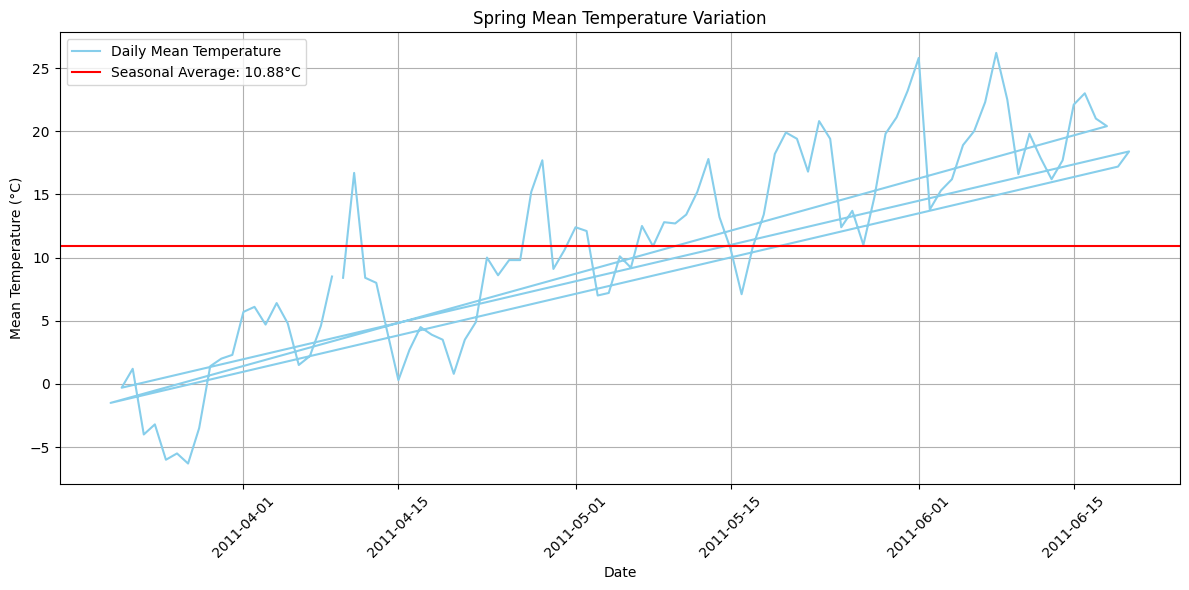

In [220]:
plot_seasonal_temps_with_avg(climate_data_gdf, 'Spring', seasonal_avg_temps)

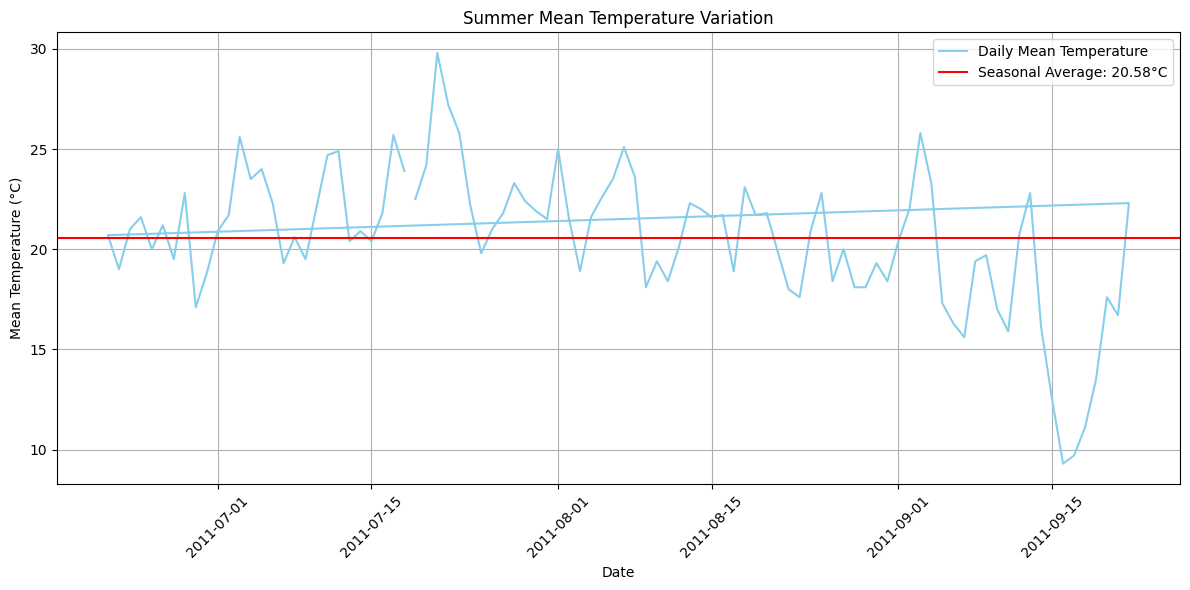

In [221]:
plot_seasonal_temps_with_avg(climate_data_gdf, 'Summer', seasonal_avg_temps)

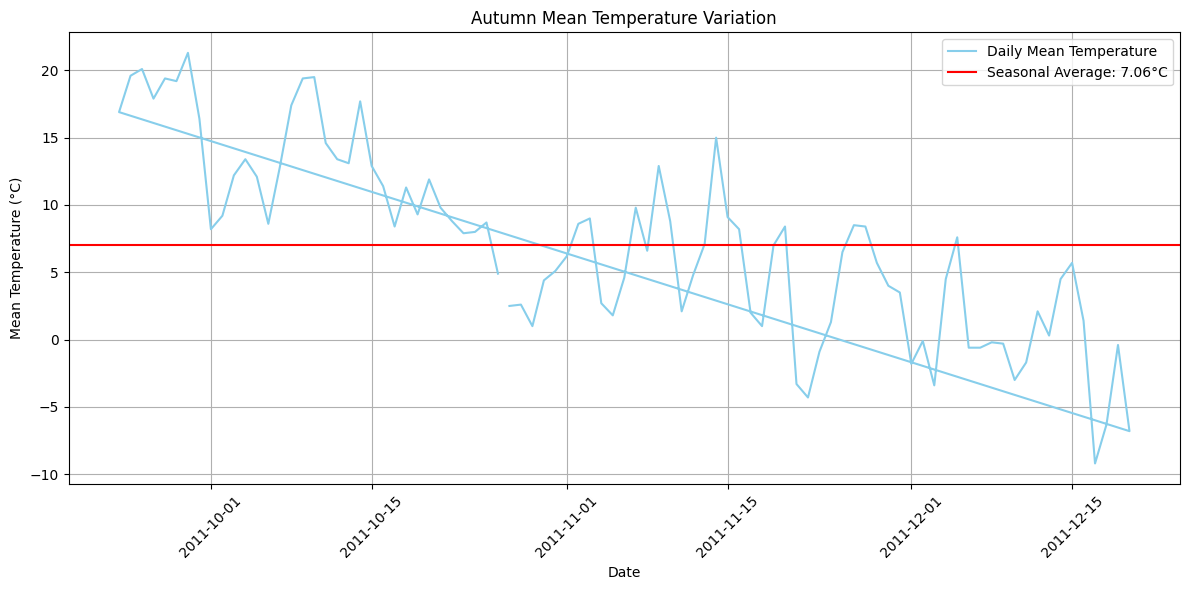

In [222]:
plot_seasonal_temps_with_avg(climate_data_gdf, 'Autumn', seasonal_avg_temps)

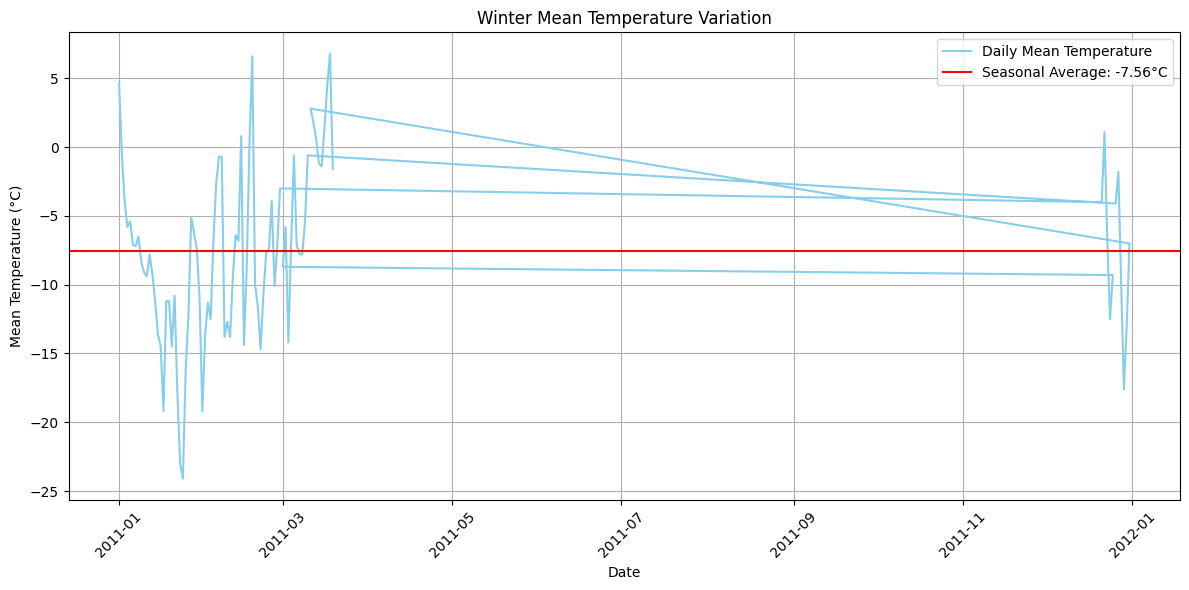

In [223]:
plot_seasonal_temps_with_avg(climate_data_gdf, 'Winter', seasonal_avg_temps)